In [1]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, confusion_matrix, roc_curve

import xgboost as xgb

import datetime

In [2]:
with open('pickle/crime_lsoa_month_prev_year_values.pkl', 'rb') as picklefile:
    crime = pickle.load(picklefile)
    
with open('pickle/imd_lsoa_2010.pkl', 'rb') as picklefile:
    imd = pickle.load(picklefile)
    
with open('pickle/census_data.pkl', 'rb') as picklefile:
    census = pickle.load(picklefile)
    
with open('pickle/borough_year.pkl', 'rb') as picklefile:
    borough_year = pickle.load(picklefile)
    
with open('pickle/borough_non_year.pkl', 'rb') as picklefile:
    borough_non_year = pickle.load(picklefile)

In [3]:
crime = crime.merge(imd, on='lsoa_code')
crime = crime.merge(census, on='lsoa_code')
crime = crime.merge(borough_non_year, on='borough')
crime = crime.merge(borough_year, on=['borough','year'])

In [4]:
crime2012_2016 = crime[crime['year']>2011]

# Looking for empty categories:
crime2012_2016.groupby('minor_category')['value'].sum()

minor_category
Assault with Injury                       221142
Burglary in Other Buildings               130136
Burglary in a Dwelling                    247813
Business Property                           9035
Common Assault                            240098
Counted per Victim                             0
Criminal Damage To Dwelling                67200
Criminal Damage To Motor Vehicle          119637
Criminal Damage To Other Building          30873
Drug Trafficking                           17820
Going Equipped                              2667
Handling Stolen Goods                       7351
Harassment                                275949
Motor Vehicle Interference & Tampering     37829
Murder                                       451
Offensive Weapon                           18186
Other Criminal Damage                      72796
Other Drugs                                 1510
Other Fraud & Forgery                          0
Other Notifiable                           58258
Other

In [5]:
# Removing empty categories
crime2012_2016 = crime2012_2016[
    (crime2012_2016['minor_category'] != 'Counted per Victim') &
    (crime2012_2016['minor_category'] != 'Other Fraud & Forgery') &
    (crime2012_2016['minor_category'] != 'Other Sexual') &
    (crime2012_2016['minor_category'] != 'Rape')
]

No crimes             0.743423
At least one crime    0.256577
Name: is_commited, dtype: float64


(array([0, 1]), <a list of 2 Text xticklabel objects>)

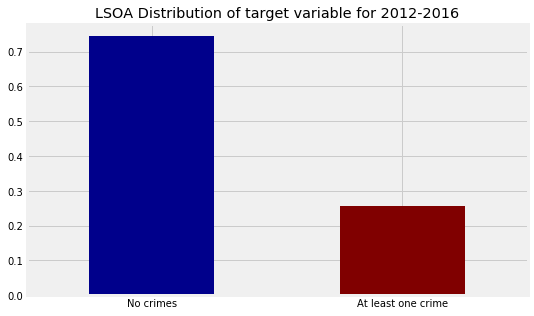

In [6]:
target_pcts = crime2012_2016['is_commited'].apply(lambda x: "No crimes" if x == 0 else "At least one crime").value_counts(normalize=True) 
print(target_pcts)

plt.figure(figsize = (8,5))
target_pcts.plot(kind='bar',color=['darkblue','maroon'])
plt.title('LSOA Distribution of target variable for 2012-2016')
plt.xticks(rotation='horizontal')

In [7]:
# Creating a sample df to better test for models
sample, rest = train_test_split(crime2012_2016, test_size=0.9, random_state=2018)

In [8]:
# with open('pickle/modeling_data/sample.pkl', 'wb') as picklefile:
#     pickle.dump(sample, picklefile)

# with open('pickle/modeling_data/sample.pkl', 'rb') as picklefile:
#     sample = pickle.load(picklefile)

In [9]:
sample = sample.fillna(-9999999)

In [10]:
sample.shape

(701730, 75)

# Sample - All Variables

In [15]:
m_all = sample.drop(['index', 'lsoa_code', 'borough', 'major_category', 'minor_category', 'value', 'date',
'day', 'datetime'], axis=1)

train = m_all[m_all['year']<2016].drop(['year','month'],axis=1)
val = m_all[(m_all['year']==2016) & (m_all['month']<7)].drop(['year','month'],axis=1)
test = m_all[(m_all['year']==2016) & (m_all['month']>6)].drop(['year','month'],axis=1)

X_train, y_train = train.drop('is_commited',axis=1), train['is_commited']
X_val, y_val = val.drop('is_commited',axis=1), val['is_commited']
X_test, y_test = test.drop('is_commited',axis=1), test['is_commited']


xg = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        scale_pos_weight = 2
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = xg.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

y_pred = xg.predict_proba(X_val)[:,1]

print(roc_auc_score(y_val, y_pred))
print(precision_score(y_val, (y_pred>0.5).astype(int)))
print(recall_score(y_val, (y_pred>0.5).astype(int)))
print(f1_score(y_val, (y_pred>0.5).astype(int)))
print(accuracy_score(y_val, (y_pred>0.5).astype(int)))


0.798517576261
0.569941876557
0.563793669916
0.566851102486
0.775956828796


In [13]:
# with open('model/xg_sample_allfeatures_weight2.pkl', 'wb') as picklefile:
#     pickle.dump(xg, picklefile)

In [14]:
# with open('model/xg_sample_allfeatures_weight2.pkl', 'rb') as picklefile:
#     xg = pickle.load(picklefile)

In [26]:
y_pred = xg.predict_proba(X_train)[:,1]

print(roc_auc_score(y_train, y_pred))
print(precision_score(y_train, (y_pred>0.5).astype(int)))
print(recall_score(y_train, (y_pred>0.5).astype(int)))
print(f1_score(y_train, (y_pred>0.5).astype(int)))
print(accuracy_score(y_train, (y_pred>0.5).astype(int)))
 
# --> not overpredicting


0.804745638946
0.564494224807
0.5765919138
0.570478940017
0.779217031132


# Choosing relevant variables

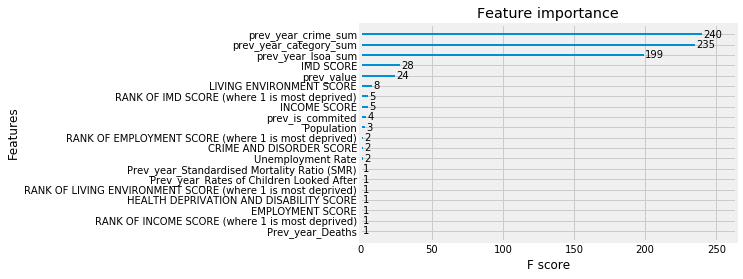

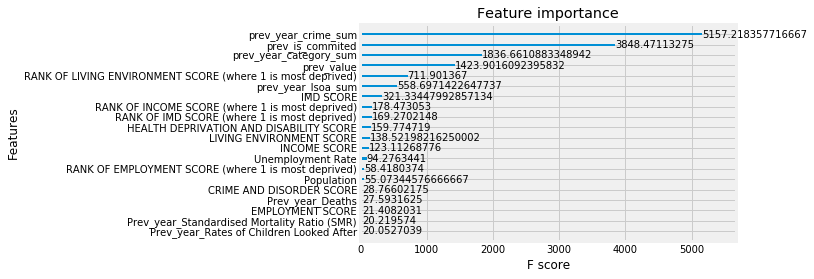

In [27]:
xgb.plot_importance(xg, max_num_features = 20)
xgb.plot_importance(xg, importance_type='gain', max_num_features = 20)

In [28]:
# Deciding which features to keep
gain = xg.get_booster().get_score(importance_type='gain')
gain = pd.DataFrame(gain, index=[0]).transpose().sort_values(by = 0, ascending = False).reset_index()
cutoff = gain[0].sum() * 0.90
gain['cumsum'] = gain[0].cumsum()

In [29]:
gain.head()

,index,0,cumsum
0,prev_year_crime_sum,5157.218358,5157.218358
1,prev_is_commited,3848.471133,9005.689490
2,prev_year_category_sum,1836.661088,10842.350579
3,prev_value,1423.901609,12266.252188
4,RANK OF LIVING ENVIRONMENT SCORE (where 1 is m...,711.901367,12978.153555


In [33]:
features_to_keep = list(gain['index'].head(20))
features_to_keep = features_to_keep + ['is_commited']

In [35]:
features_to_keep= ['prev_year_crime_sum',
 'prev_is_commited',
 'prev_year_category_sum',
 'prev_value',
 'RANK OF LIVING ENVIRONMENT SCORE (where 1 is most deprived)',
 'prev_year_lsoa_sum',
 'IMD SCORE',
 'RANK OF INCOME SCORE (where 1 is most deprived)',
 'RANK OF IMD SCORE (where 1 is most deprived)',
 'HEALTH DEPRIVATION AND DISABILITY SCORE',
 'LIVING ENVIRONMENT SCORE',
 'INCOME SCORE',
 'Unemployment Rate',
 'RANK OF EMPLOYMENT SCORE (where 1 is most deprived)',
 'Population',
 'CRIME AND DISORDER SCORE',
 'Prev_year_Deaths',
 'EMPLOYMENT SCORE',
 'Prev_year_Standardised Mortality Ratio (SMR)',
 'Prev_year_Rates of Children Looked After',
 'is_commited']

In [36]:
variablenames = ['Prev year by LSOA & type',
 'Prev month target',
 'Prev year category',
 'Prev month crime value',
 'Living environment rank',
 'Prev year LSOA',
 'IMD Score',
 'Income Score rank',
 'IMD Score rank',
 'Health deprivation and disability score',
 'Living environment score',
 'Income score',
 'Unemployment Rate',
 'Rank of employment score',
 'Population',
 'Crime and disorder score',
 'Prev year deaths',
 'Employment score',
 'Prev year mortality ratio',
 'Prev year rates of children looked after']

In [37]:
gain10 = (gain.head(10)
          .sort_values(by=0,ascending=True)
          .merge(pd
                 .DataFrame({'index':features_to_keep[:-1],'new':variablenames}),on='index',how='left'))


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text yticklabel objects>)

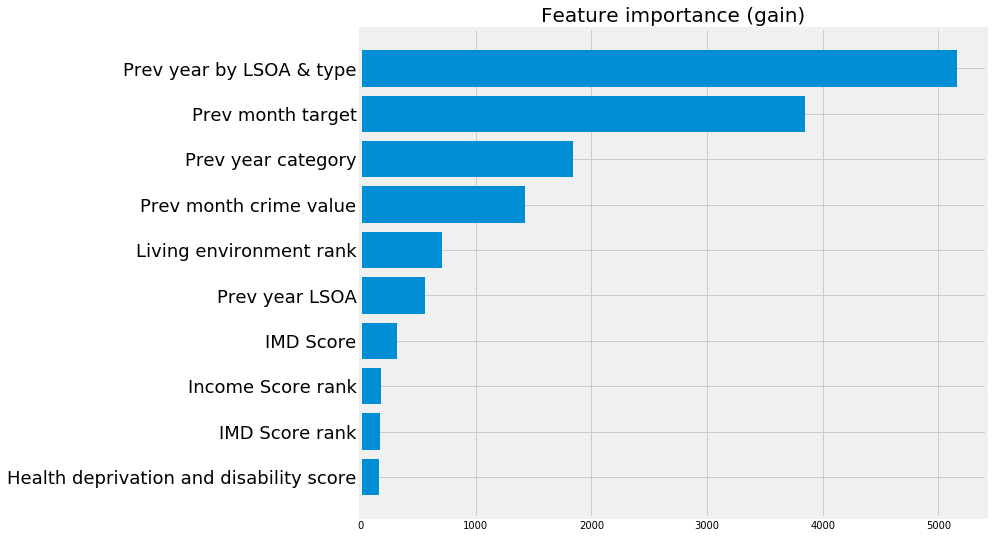

In [41]:
plt.figure(figsize =(10,9))
plt.barh(gain10['new'],gain10[0])
plt.title('Feature importance (gain)',fontsize = 20)
plt.yticks(fontsize=18)

# Sample - Relevant variables

In [153]:
features_to_keep = features_to_keep + ['year','month']
m_relevant = sample[features_to_keep]

train = m_relevant[m_relevant['year']<2016].drop(['year','month'],axis=1)
val = m_relevant[(m_relevant['year']==2016) & (m_relevant['month']<7)].drop(['year','month'],axis=1)
test = m_relevant[(m_relevant['year']==2016) & (m_relevant['month']>6)].drop(['year','month'],axis=1)

X_train, y_train = train.drop('is_commited',axis=1), train['is_commited']
X_val, y_val = val.drop('is_commited',axis=1), val['is_commited']
X_test, y_test = test.drop('is_commited',axis=1), test['is_commited']


xg_relevant = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        scale_pos_weight = 2
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = xg_relevant.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

y_pred = xg_relevant.predict_proba(X_val)[:,1]

print(roc_auc_score(y_val, y_pred))
print(precision_score(y_val, (y_pred>0.5).astype(int)))
print(recall_score(y_val, (y_pred>0.5).astype(int)))
print(f1_score(y_val, (y_pred>0.5).astype(int)))
print(accuracy_score(y_val, (y_pred>0.5).astype(int)))

0.798419114719
0.569941876557
0.563793669916
0.566851102486
0.775956828796


In [16]:
# Checking overprediction
y_pred = xg_relevant.predict_proba(X_train)[:,1]

print(roc_auc_score(y_train, y_pred))
print(precision_score(y_train, (y_pred>0.5).astype(int)))
print(recall_score(y_train, (y_pred>0.5).astype(int)))
print(f1_score(y_train, (y_pred>0.5).astype(int)))
print(accuracy_score(y_train, (y_pred>0.5).astype(int)))

# Threshold tunning

In [17]:
# Didn't use it because I used the weighting in xgboost.
# Make sure that thresh_ps is in the range of predict_proba, otherwise it gives error

y_pred = xg_relevant.predict_proba(X_val)[:,1]
thresh_ps = np.linspace(.10,.9,1000)

f1_scores = []
for p in thresh_ps:
    model_val_labels = y_pred >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores,label='F1')
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')
plt.legend()

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Gradient Boosting Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

ac_scores = []
for p in thresh_ps:
    model_val_labels = y_pred >= p
    ac_scores.append(accuracy_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, ac_scores,label='Accuracy')
plt.legend()
#plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
#plt.xlabel('P threshold')
#plt.ylabel('F1 score')

best_ac_score = np.max(ac_scores) 
best_thresh_ac = thresh_ps[np.argmax(ac_scores)]

print('Gradient Boosting Model best Accuracy score %.3f at prob decision threshold >= %.3f' 
      % (best_ac_score, best_thresh_ac))

pr_scores = []
for p in thresh_ps:
    model_val_labels = y_pred >= p
    pr_scores.append(precision_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, pr_scores,label='Precision')
plt.legend()
#plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
#plt.xlabel('P threshold')
#plt.ylabel('F1 score')

best_pr_score = np.max(pr_scores) 
best_thresh_pr = thresh_ps[np.argmax(pr_scores)]

print('Gradient Boosting Model best Precision score %.3f at prob decision threshold >= %.3f' 
      % (best_pr_score, best_thresh_pr))

rec_scores = []
for p in thresh_ps:
    model_val_labels = y_pred >= p
    rec_scores.append(recall_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, rec_scores,label='Recall')
plt.legend()
#plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
#plt.xlabel('P threshold')
#plt.ylabel('F1 score')

best_rec_score = np.max(rec_scores) 
best_thresh_rec = thresh_ps[np.argmax(rec_scores)]

print('Gradient Boosting Model best Recall score %.3f at prob decision threshold >= %.3f' 
      % (best_rec_score, best_thresh_rec))


In [31]:
y_pred = xg_relevant.predict(X_val)

print(roc_auc_score(y_val, y_pred))
print(precision_score(y_val, (y_pred>best_thresh_p).astype(int)))
print(recall_score(y_val, (y_pred>best_thresh_p).astype(int)))
print(f1_score(y_val, (y_pred>best_thresh_p).astype(int)))
print(accuracy_score(y_val, (y_pred>best_thresh_p).astype(int)))

0.820895608878
0.510339123242
0.700243591873
0.590396172472
0.756540617024


In [3]:
with open('model/xg_sample_relevant.pkl', 'wb') as picklefile:
    pickle.dump(xg_relevant, picklefile)

In [52]:
# Checking on how last month crime predicts current crime

print(roc_auc_score(crime2012_2016['is_commited'], crime2012_2016['prev_is_commited']))
print(precision_score(crime2012_2016['is_commited'], crime2012_2016['prev_is_commited']))
print(recall_score(crime2012_2016['is_commited'], crime2012_2016['prev_is_commited']))
print(f1_score(crime2012_2016['is_commited'], crime2012_2016['prev_is_commited']))
print(accuracy_score(crime2012_2016['is_commited'], crime2012_2016['prev_is_commited']))


0.652175338787
0.478352517158
0.477820093631
0.47808615716
0.739435631093


# Trying different models

In [41]:
m_relevant = sample[features_to_keep]

X, y = m_relevant.drop('is_commited',axis=1), m_relevant['is_commited']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2019)

lg = LogisticRegression(C=1000, solver='liblinear')
lg.fit(X_train,y_train)


y_pred = lg.predict(X_val)



/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 1000.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [42]:
print(roc_auc_score(y_val, y_pred))
print(precision_score(y_val, (y_pred>0.5).astype(int)))
print(recall_score(y_val, (y_pred>0.5).astype(int)))
print(f1_score(y_val, (y_pred>0.5).astype(int)))
print(accuracy_score(y_val, (y_pred>0.5).astype(int)))

0.593822043948
0.624227714034
0.234927752865
0.341378062025
0.772860947731


Logistic Regression Model best F1 score 0.542 at prob decision threshold >= 0.249
Logistic Regression Model best Accuracy score 0.776 at prob decision threshold >= 0.428
Logistic Regression Model best Precision score 0.975 at prob decision threshold >= 0.100
Logistic Regression Model best Recall score 0.819 at prob decision threshold >= 0.899


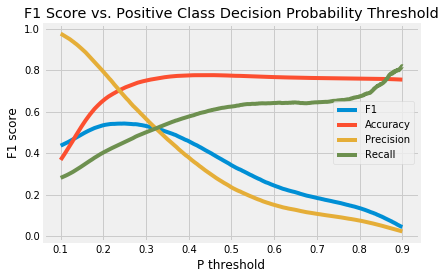

In [45]:
y_pred = lg.predict_proba(X_val)[:,1]

thresh_ps = np.linspace(.10,.9,1000)

f1_scores = []
for p in thresh_ps:
    model_val_labels = y_pred >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores,label='F1')
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')
plt.legend()

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

ac_scores = []
for p in thresh_ps:
    model_val_labels = y_pred >= p
    ac_scores.append(accuracy_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, ac_scores,label='Accuracy')
plt.legend()
#plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
#plt.xlabel('P threshold')
#plt.ylabel('F1 score')

best_ac_score = np.max(ac_scores) 
best_thresh_ac = thresh_ps[np.argmax(ac_scores)]

print('Logistic Regression Model best Accuracy score %.3f at prob decision threshold >= %.3f' 
      % (best_ac_score, best_thresh_ac))

pr_scores = []
for p in thresh_ps:
    model_val_labels = y_pred >= p
    pr_scores.append(precision_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, pr_scores,label='Precision')
plt.legend()
#plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
#plt.xlabel('P threshold')
#plt.ylabel('F1 score')

best_pr_score = np.max(pr_scores) 
best_thresh_pr = thresh_ps[np.argmax(pr_scores)]

print('Logistic Regression Model best Precision score %.3f at prob decision threshold >= %.3f' 
      % (best_pr_score, best_thresh_pr))

rec_scores = []
for p in thresh_ps:
    model_val_labels = y_pred >= p
    rec_scores.append(recall_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, rec_scores,label='Recall')
plt.legend()
#plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
#plt.xlabel('P threshold')
#plt.ylabel('F1 score')

best_rec_score = np.max(rec_scores) 
best_thresh_rec = thresh_ps[np.argmax(rec_scores)]

print('Logistic Regression Model best Recall score %.3f at prob decision threshold >= %.3f' 
      % (best_rec_score, best_thresh_rec))



## Year comparison

In [56]:
for year in [2012,2013,2014,2015,2016]:
    m_relevant = crime2012_2016[crime2012_2016['year']==year][features_to_keep]

    X, y = m_relevant.drop('is_commited',axis=1), m_relevant['is_commited']

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2019)

    xg_relevant = xgb.XGBRegressor( 
                           n_estimators=30000, #arbitrary large number
                           max_depth=3,
                           objective="reg:linear",
                           learning_rate=.1, 
                           subsample=1,
                           min_child_weight=1,
                           colsample_bytree=.8
                          )

    eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
    fit_model = xg_relevant.fit( 
                        X_train, y_train, 
                        eval_set=eval_set,
                        eval_metric='rmse',
                        early_stopping_rounds=50,
                        verbose=False #gives output log as below
                       )
    with open('model/xg_relevant_year_%d.pkl'%year, 'wb') as picklefile:
        pickle.dump(xg_relevant, picklefile)

    y_pred = xg_relevant.predict(X_val)

    print('Year: ', year)
    print(roc_auc_score(y_val, y_pred))
    print(precision_score(y_val, (y_pred>0.5).astype(int)))
    print(recall_score(y_val, (y_pred>0.5).astype(int)))
    print(f1_score(y_val, (y_pred>0.5).astype(int)))
    print(accuracy_score(y_val, (y_pred>0.5).astype(int)))
    print("")

Year:  2012
0.836619402889
0.672444584515
0.44437810669
0.535124606034
0.807155168527

Year:  2013
0.828943050272
0.668009247122
0.403126752866
0.502816446613
0.807769003749

Year:  2014
0.824787888019
0.664246823956
0.398585672866
0.498214475126
0.803128825633

Year:  2015
0.826067677487
0.675878440418
0.413520956935
0.513108232174
0.801367083867

Year:  2016
0.826996363001
0.679038781823
0.419627342476
0.518707609441
0.797958044189



#### Trying different sample weights. Keeping scale_pos_weight = 2

In [ ]:
# scale_pos_weight = 2
0.798517576261
0.569941876557
0.563793669916
0.566851102486
0.775956828796

In [ ]:
# Result with resampling 0.8
0.809948639105
0.706060946812
0.343828715365
0.462456269564
0.792160268823

In [ ]:
# Result with resampling of 0.4
0.799241362237
0.846715328467
0.146095717884
0.249194414608
0.771087253674

In [133]:
# Result with resampling of 0.25
0.810232160088
0.891634156914
0.11263826525
0.20000972337
0.765705091696

0.765705091696

In [131]:
#Result without resampling

0.809444326037
0.666908826734
0.402146533786
0.501742160279
0.792316892585


In [4]:
with open('pickle/crime_lsoa_month_prev_year_values.pkl', 'rb') as picklefile:
    crime = pickle.load(picklefile)

## Full model (importing trained model from aws)

In [42]:
with open('model/xgbfull_relevant.pkl', 'rb') as picklefile:
    xgbfull_relevant = pickle.load(picklefile)

In [18]:
crime2012_2016 = crime.fillna(-9999999)
crime2012_2016 = crime2012_2016[
    (crime2012_2016['minor_category'] != 'Counted per Victim') &
    (crime2012_2016['minor_category'] != 'Other Fraud & Forgery') &
    (crime2012_2016['minor_category'] != 'Other Sexual') &
    (crime2012_2016['minor_category'] != 'Rape')
]

In [ ]:
features_to_keep = ['prev_year_crime_sum',
 'prev_is_commited',
 'prev_year_category_sum',
 'prev_value',
 'RANK OF LIVING ENVIRONMENT SCORE (where 1 is most deprived)',
 'prev_year_lsoa_sum',
 'IMD SCORE',
 'RANK OF INCOME SCORE (where 1 is most deprived)',
 'RANK OF IMD SCORE (where 1 is most deprived)',
 'HEALTH DEPRIVATION AND DISABILITY SCORE',
 'LIVING ENVIRONMENT SCORE',
 'INCOME SCORE',
 'Unemployment Rate',
 'RANK OF EMPLOYMENT SCORE (where 1 is most deprived)',
 'Population',
 'CRIME AND DISORDER SCORE',
 'Prev_year_Deaths',
 'EMPLOYMENT SCORE',
 'Prev_year_Standardised Mortality Ratio (SMR)',
 'Prev_year_Rates of Children Looked After',
 'is_commited']

features_to_keep = features_to_keep + ['year']
m_relevant = crime2012_2016[features_to_keep]

train = m_relevant[m_relevant['year']<2016].drop(['year'],axis=1)
test = m_relevant[(m_relevant['year']==2016)].drop(['year'],axis=1)

X_train, y_train = train.drop('is_commited',axis=1), train['is_commited']
X_test, y_test = test.drop('is_commited',axis=1), test['is_commited']

In [ ]:
y_pred = xgbfull_relevant.predict_proba(X_test)[:,1]

In [ ]:
print(roc_auc_score(y_test, y_pred))
print(precision_score(y_test, (y_pred>0.5).astype(int)))
print(recall_score(y_test, (y_pred>0.5).astype(int)))
print(f1_score(y_test, (y_pred>0.5).astype(int)))
print(accuracy_score(y_test, (y_pred>0.5).astype(int)))

In [149]:
confusion_matrix(y_test,(y_pred>0.5).astype(int))

array([[854750, 175316],
       [147419, 225975]])